In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas
import pointprocesses as ppr

In [3]:
import torch

# Données synthétiques

In [4]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

In [5]:
import itertools
mu = 1.0
tmax = 5.0
alpha = 0.25
beta  = 2.0

print("Expected avg evt no. %.3f" % (tmax*mu/(1.-alpha)))

Expected avg evt no. 6.667


In [6]:
n_traj = 400
sample_trajectories = [ppr.hawkes_exp(tmax, beta, mu, itertools.repeat(alpha)) for _ in range(n_traj)]

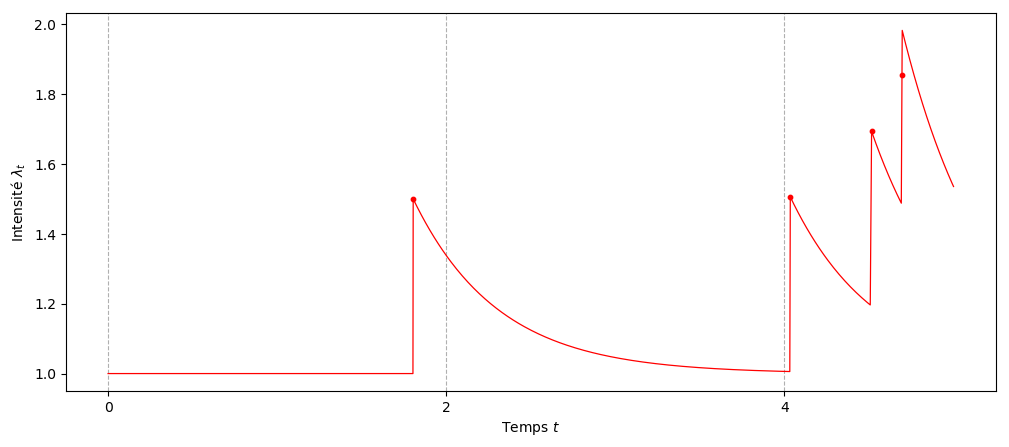

In [7]:
one_traj = sample_trajectories[0]
fig, ax = plt.subplots(1,1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel(r"Intensité $\lambda_t$")
t_arr = np.sort(np.append(np.linspace(0, tmax, 600), one_traj[:,]))
ax.plot(t_arr, intensity_function(t_arr, mu, alpha, beta, one_traj[:,0]), 'r-', linewidth=0.9)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.))
scatter_opts = {
    "c": "r", "s": 11
}
ax.grid(True, axis='x', linestyle='--')
ax.scatter(one_traj[:,0], one_traj[:,1], c='r', s=10)

We will pad each sequence with 0s at the end.

In [8]:
print("Number of samples: \t\t%d" % len(sample_trajectories))
seq_lengths = torch.LongTensor([s.shape[0] for s in sample_trajectories])+1
input_size = seq_lengths.max().item()
print("Input size max. traj. length: \t%d" % input_size)
print("tmax = %.3f"  % tmax)
data_array = np.stack([
    np.pad(s[:,0], ((0, input_size - s.shape[0] - 1)), 'constant') for s in sample_trajectories
])
data_tensor = torch.from_numpy(data_array).to(torch.float32)

# Add a beginning-of-sequence event:
data_tensor = torch.cat((torch.zeros(data_tensor.shape[0],1), data_tensor), dim=1)

Number of samples: 		400
Input size max. traj. length: 	19
tmax = 5.000


In [9]:
data_tensor.shape

torch.Size([400, 19])

The first dimension is for time, the second for the sample.

## Neural net

In [10]:
import torch
import torch.nn as nn
from torch import optim

In [11]:
device = torch.device("cpu")
print(device)

cpu


In [12]:
torch.manual_seed(1)

$$
    \lambda_k(t) = f_k(\mathbf w_k^\intercal\mathbf h(t))
$$

$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i]
$$

In [24]:
from model import NeuralCTLSTM
import tqdm

In [25]:
# We use mini-batches to train on our data
BATCH_SIZE = 40
print("Batch size: %d" % BATCH_SIZE)
print("Training sample size: %d" % data_tensor.size(0))
print("Splitting into batches of %d" % BATCH_SIZE)
split_into_batches = data_tensor.split(BATCH_SIZE, dim=0)
num_of_batches = len(split_into_batches)
print("No. of batches: %d" % num_of_batches)

hidden_size = 8
learn_rate = 0.0008

nhlstm = NeuralCTLSTM(hidden_size)
optimizer = optim.SGD(nhlstm.parameters(), lr=learn_rate)

Batch size: 40
Training sample size: 400
Splitting into batches of 40
No. of batches: 10


In [26]:
# batch_range = tqdm.trange(num_of_batches)
# batch_range = tqdm.trange(data_tensor.size(0))
train_size = 400
batch_range = tqdm.trange(train_size)
loss_hist = []
for i in batch_range:
    batch_range.set_description("Batch %d" % i)
    # sample's event times
    event_times = data_tensor[i]
    dt = event_times[1:] - event_times[:-1]
    ## Train on each batch
    # event_times = split_into_batches[i]
    # inter_t = event_times[:,:-1] - event_times[:,1:] # transform into inter-arrival times
    # batch_size = inter_t.size(0)
    output_hist = []
    hidden_hist = []
    cell_hist = []
    cell_target_hist = []
    decay_hist = []
    # Initialize hidden and cell state at 0
    hidden, cti, cbar = nhlstm.init_hidden()
    # Reset gradients; in PyTorch they accumulate
    nhlstm.zero_grad()
    # Loop over event times
    # First pass takes care of the interval [0,t1) before first event
    for j in range(input_size - 1):
        output, hidden, cti, cell_t, cbar, decay_t = nhlstm(dt[j], hidden, cti, cbar)
        output_hist.append(output)
        hidden_hist.append(hidden)
        cell_hist.append(cti)
        cell_target_hist.append(cbar)
        decay_hist.append(decay_t)
    output_hist = torch.stack(output_hist, dim=1)
    hidden_hist = torch.stack(hidden_hist, dim=1)
    cell_hist = torch.stack(cell_hist, dim=1)
    cell_target_hist = torch.stack(cell_target_hist, dim=1)
    decay_hist = torch.stack(decay_hist, dim=1)
    loss = nhlstm.likelihood(event_times, seq_lengths[i], cell_hist, cell_target_hist, output_hist, decay_hist, tmax)
    # Compute the gradients
    loss.backward()
    # Update the model parameters
    optimizer.step()
    loss_val = loss.item()
    batch_range.set_postfix(loss=loss_val)
    loss_hist.append(loss_val) # record the loss value


Batch 399: 100%|██████████| 400/400 [00:11<00:00, 35.68it/s, loss=-8.34]


Each training loop:
* reinitializes the hidden state weights
* zeroes the gradients
* computes the loss

Text(0.5, 1.0, 'Loss = negative log-likelihood')

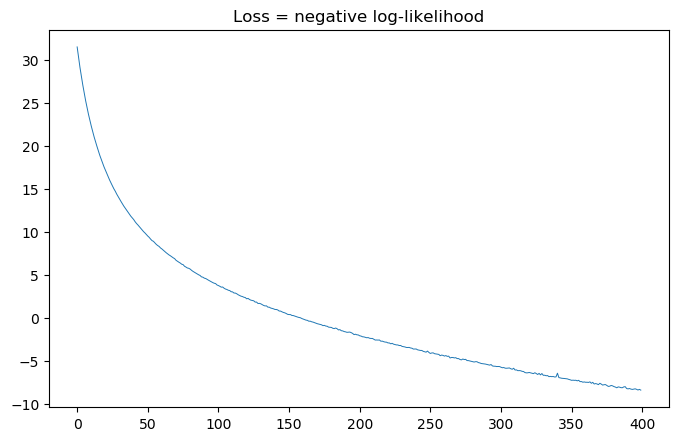

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
lineopts = {
    "linewidth": 0.7
}
ax.plot(range(train_size), loss_hist, **lineopts)
ax.set_title("Loss = negative log-likelihood")

In [60]:
grid = torch.from_numpy(np.linspace(0,1,11))

In [61]:
grid

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000], dtype=torch.float64)

In [70]:
tar, _ = torch.rand(11, dtype=torch.float64).sort(0)

In [71]:
tar

tensor([0.0029, 0.0441, 0.0862, 0.1899, 0.3177, 0.3932, 0.6351, 0.6634, 0.8085,
        0.9720, 0.9771], dtype=torch.float64)

In [86]:
indices = torch.sum(tar[:,None] >= grid, dim=1)-1
indices

tensor([0, 0, 0, 1, 3, 3, 6, 6, 8, 9, 9])

In [87]:
grid[indices]

tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.3000, 0.3000, 0.6000, 0.6000, 0.8000,
        0.9000, 0.9000], dtype=torch.float64)

In [101]:
(grid[1:] - grid[:-1])[indices]

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000], dtype=torch.float64)

In [76]:
big_grid = torch.from_numpy(np.linspace(-3.16, 3.16, 80))

In [77]:
big_grid

tensor([-3.1600, -3.0800, -3.0000, -2.9200, -2.8400, -2.7600, -2.6800, -2.6000,
        -2.5200, -2.4400, -2.3600, -2.2800, -2.2000, -2.1200, -2.0400, -1.9600,
        -1.8800, -1.8000, -1.7200, -1.6400, -1.5600, -1.4800, -1.4000, -1.3200,
        -1.2400, -1.1600, -1.0800, -1.0000, -0.9200, -0.8400, -0.7600, -0.6800,
        -0.6000, -0.5200, -0.4400, -0.3600, -0.2800, -0.2000, -0.1200, -0.0400,
         0.0400,  0.1200,  0.2000,  0.2800,  0.3600,  0.4400,  0.5200,  0.6000,
         0.6800,  0.7600,  0.8400,  0.9200,  1.0000,  1.0800,  1.1600,  1.2400,
         1.3200,  1.4000,  1.4800,  1.5600,  1.6400,  1.7200,  1.8000,  1.8800,
         1.9600,  2.0400,  2.1200,  2.2000,  2.2800,  2.3600,  2.4400,  2.5200,
         2.6000,  2.6800,  2.7600,  2.8400,  2.9200,  3.0000,  3.0800,  3.1600],
       dtype=torch.float64)

In [78]:
torch.sigmoid(big_grid)

tensor([0.0407, 0.0439, 0.0474, 0.0512, 0.0552, 0.0595, 0.0642, 0.0691, 0.0745,
        0.0802, 0.0863, 0.0928, 0.0998, 0.1072, 0.1151, 0.1235, 0.1324, 0.1419,
        0.1519, 0.1625, 0.1736, 0.1854, 0.1978, 0.2108, 0.2244, 0.2387, 0.2535,
        0.2689, 0.2850, 0.3015, 0.3186, 0.3363, 0.3543, 0.3729, 0.3917, 0.4110,
        0.4305, 0.4502, 0.4700, 0.4900, 0.5100, 0.5300, 0.5498, 0.5695, 0.5890,
        0.6083, 0.6271, 0.6457, 0.6637, 0.6814, 0.6985, 0.7150, 0.7311, 0.7465,
        0.7613, 0.7756, 0.7892, 0.8022, 0.8146, 0.8264, 0.8375, 0.8481, 0.8581,
        0.8676, 0.8765, 0.8849, 0.8928, 0.9002, 0.9072, 0.9137, 0.9198, 0.9255,
        0.9309, 0.9358, 0.9405, 0.9448, 0.9488, 0.9526, 0.9561, 0.9593],
       dtype=torch.float64)

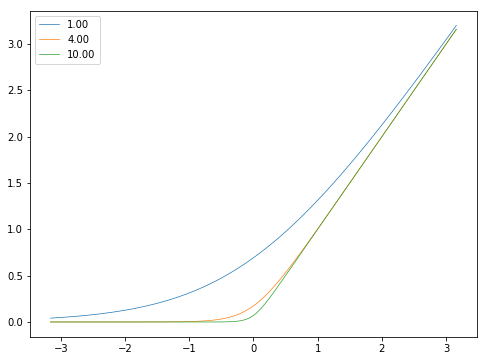

In [101]:
plt.figure(figsize=(8,6))
for b in [1, 4, 10]:
    yvals = nn.Softplus(threshold=10, beta=b)(big_grid)
    plt.plot(big_grid.tolist(), yvals.tolist(), linewidth=.7, label='%.2f' % b)
plt.legend()